# Galaxy zoo image classification - basics with PyTorch

> Marc Huertas-Company & Alexandre Boucaud  
> Ecole Rodolphe Cledassou 2024

## Loading and exploring the data

In [1]:
import torch
import numpy as np

from datasets import load_dataset

train_set = load_dataset("imagefolder", data_dir="../datasets/euclid-school", split="train")
# splits = load_dataset("imagefolder", data_dir="../datasets/euclid-school", split="train").train_test_split(0.1)
# train_set, val_set = splits["train"], splits["test"]

test_set = load_dataset("imagefolder", data_dir="../datasets/euclid-school", split="test")

Resolving data files:   0%|          | 0/2760 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/691 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/2760 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/691 [00:00<?, ?it/s]

In [26]:
classes = train_set.features['label']

classes

ClassLabel(names=['featured', 'problem', 'smooth'], id=None)

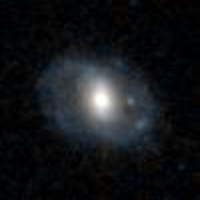

In [27]:
train_set[0]['image'].resize((200, 200))

In [28]:
classes.int2str(train_set[0]['label'])

'featured'

## Defining data augmentations

This will use the transformations defined in https://albumentations.ai/docs/ to augment the datasets

In [3]:
import albumentations as A

data_augmentation_pipeline = A.Compose([
    A.Rotate(limit=180, interpolation=1,
                always_apply=True, border_mode=0, value=0),
    A.RandomResizedCrop(
        height=224,  # after crop resize
        width=224,
        scale=(0.7, 0.8),  # crop factor
        ratio=(0.9, 1.1),  # crop aspect ratio
        interpolation=1,  # This is "INTER_LINEAR" == BILINEAR interpolation. See: https://docs.opencv.org/3.4/da/d54/group__imgproc__transform.html
        always_apply=True
    ),  # new aspect ratio
    A.VerticalFlip(p=0.5),
    A.ToFloat(max_value=255.0, always_apply=True),
])    

def augment_func(samples):
    samples["pixel_values"] = [
        data_augmentation_pipeline(image=np.array(image))["image"] for image in samples["image"]
    ]
    return samples

train_set.set_transform(augment_func)

However we don't want these augmentations to be applied to the test images. We only want to standardize them.

In [ ]:

standardization_pipeline = A.Compose([
    A.Resize(height=224, width=224, interpolation=1), 
    A.ToFloat(max_value=255.0, always_apply=True),
])

def standardize_func(samples):
    samples["pixel_values"] = [
        standardization_pipeline(image=np.array(image))["image"] for image in samples["image"]
    ]
    return samples

test_set.set_transform(standardize_func)

## Creating a convolutional network to extract features from the images from scratch

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1)
        self.conv3 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 4)
        x = self.dropout1(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


net = Net()

The loss function for this classification problem will be a cross entropy loss.

We also set up the optimizer for the training phase.

In [ ]:
import torch.optim as optim

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)

Before we start training, we can create a dataloader that will take the sample images from the dataset by batch of `batch_size`, apply the data augmentation and feed them to the neural network following a scheme defined in the `collate_fn` function below.

In [6]:
batch_size = 8

def collate_fn(examples):
    pixel_values = torch.stack([torch.tensor(example["pixel_values"]) for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return  pixel_values.permute(0, 3, 1, 2), labels

trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, collate_fn=collate_fn)

testloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=False, collate_fn=collate_fn)

## Training

This is the training script that will run for a number of epochs

In [8]:
N_EPOCHS = 3

for epoch in range(N_EPOCHS):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 30 == 0:
            print(f'Epoch {epoch + 1:2d}, batch {i + 1:3d}] | loss: {running_loss / 30:.3f}')
            running_loss = 0.0

print('Finished Training')

Epoch  1, batch   1] | loss: 0.076
Epoch  1, batch  31] | loss: 2.267
Epoch  1, batch  61] | loss: 2.243
Epoch  1, batch  91] | loss: 2.211
Epoch  1, batch 121] | loss: 2.180
Epoch  1, batch 151] | loss: 2.150
Epoch  1, batch 181] | loss: 2.109
Epoch  1, batch 211] | loss: 2.063
Epoch  1, batch 241] | loss: 2.004
Epoch  1, batch 271] | loss: 1.931
Epoch  1, batch 301] | loss: 1.836
Epoch  1, batch 331] | loss: 1.666
Epoch  2, batch   1] | loss: 0.048
Epoch  2, batch  31] | loss: 1.368
Epoch  2, batch  61] | loss: 1.220
Epoch  2, batch  91] | loss: 1.048
Epoch  2, batch 121] | loss: 0.918
Epoch  2, batch 151] | loss: 0.989
Epoch  2, batch 181] | loss: 0.899
Epoch  2, batch 211] | loss: 0.955
Epoch  2, batch 241] | loss: 0.933
Epoch  2, batch 271] | loss: 0.972
Epoch  2, batch 301] | loss: 0.912
Epoch  2, batch 331] | loss: 0.877
Epoch  3, batch   1] | loss: 0.023
Epoch  3, batch  31] | loss: 0.878
Epoch  3, batch  61] | loss: 0.961
Epoch  3, batch  91] | loss: 0.890
Epoch  3, batch 121]

After training we can save the model state into a file so we can load it back again later.

In [9]:
torch.save(net.state_dict(), 'convnet.pth')

In [10]:
net = Net()
net.load_state_dict(torch.load('convnet.pth'))

/var/folders/19/jwzphgd14_ldbmfxmnbf8hxr0000gq/T/ipykernel_14948/2640860010.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('convnet.pth')

<All keys matched successfully>

## Model evaluation

Finally we can evaluate the network on the test data

In [11]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 52 %


## Exercices

You job, if you accept it, is to improve the accuracy of the model.

To do so, here are some ideas:
- try new data augmentations from the Albumentations package (https://albumentations.ai/docs/)
- explore new CNN architectures found on the web (GitHub, Kaggle, arXiv..)
- look at the effect of the learning rate, epochs and batch_size on the training loss